<a href="https://colab.research.google.com/github/HernanJMaurice/androidSensors/blob/main/HPC/Maurice_Hernan_Ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introduccion

  Las secuencias de ADN se pueden comparar entre ellas, sobre todo cuando poseen un "ancestro" en común. Durante la evolución se pueden producir sustituciones, inserciones o eliminaciones de nucleótidos. De esta forma, se puede ver la cantidad de "Matches" veces que la secuencia tiene los mismos nucleótidos, la cantidad de "Mismatches", veces que la secuencia posee diferentes nucleótidos y la cantidad de "Gaps" veces en que en la secuencia ocurrió una eliminación. 

  De esta forma se pueden obtener estadísticas sobre el parecido de especies de seres vivos, virus o incluso alimentos si hablamos de cadenas de proteínas. 

  En este programa se busca realizar la comparación de secuencias de ADN y la obtención de la cantidad de Mismatch, Match y gaps que poseen.

# 2 Armado de Ambiente

Primero debemos instalar "requests" que se utiliza para hacer requests a las APIs. Esto se utilizará para la notificacion a la aplicacion de sensores de android.

  Luego ejecute el codgio de C para preparar el generar el archivo .c el cual posee el algoritmo de comparacion de secuencias de ADN utilizando MPI.

  Compile el archivo .c para prepararlo para su ejecucion.

  Utilize el codigo de preparacion de ejecucion para ingresar las dos cadenas de ADN y que éste le devuelva la linea que deberá ejecutar en la seccion "Ejecutar programa".

  Finalmente copie la linea y ejecutela.

  

# 3 Ejecucion

# 3.1 Instalacion Requests

In [2]:
pip install requests


# 3.2 Generacion de Codigo C

In [3]:
code = """

#include <string.h>
#include <stdio.h>
#include <mpi.h>
#include<stdlib.h>

int main(int argc, char** argv)
{
  int myRank, numProcs;
  int tag=1;
  int lenght = atoi(argv[3]);
  char mensaje[4];
  char mensajeRespuesta[100];
  char respuesta[lenght];
  MPI_Status status;
  int match = 0;
  int mismatch = 0;
  int gap = 0;

  MPI_Init(NULL, NULL);

  MPI_Comm_rank( MPI_COMM_WORLD, &myRank );
  MPI_Comm_size( MPI_COMM_WORLD, &numProcs );

  //Si No es el primer proceso Ejecuta
  if( myRank != 0 )
  {
      int dest = 0;
      //El proceso "i" (distinto a 0) espera el mensaje del proceso 0
      MPI_Recv(&mensaje, 4, MPI_CHAR, 0, tag, MPI_COMM_WORLD, &status);

      // El proceso "i" realiza el calculo sobre los datos.
      if(mensaje[0] == mensaje[1])
      {

          sprintf( mensajeRespuesta, "|" );

      }else if( mensaje[0] == '-' || mensaje[1]== '-')
      {
          sprintf( mensajeRespuesta, " " );
      }else
      {
          sprintf( mensajeRespuesta, "*" );
      }

      //El proceso "i" se prepara para enviar la respuesta al Proceso 0
      MPI_Send(&mensajeRespuesta, strlen(mensajeRespuesta), MPI_CHAR, dest, tag, MPI_COMM_WORLD);

  }
  else
  {
    
    //ENVIO DE DATOS
    for(int i=1; i<numProcs; i++)
    {
        // El proceso 0 prepara los datos
        strcpy(mensaje, "");
        if(i < strlen(argv[1]) && i < strlen(argv[2]))
        {  
            sprintf( mensaje, "%c%c", argv[1][i-1], argv[2][i-1] );	
        }else if( i <= strlen(argv[1]) && i > strlen(argv[2]) )
        {
            sprintf( mensaje, "%c-", argv[1][i-1]);	
        }else if( i > strlen(argv[1]) && i <= strlen(argv[2]) )
        {
            sprintf( mensaje, "-%c", argv[2][i-1]);	
        }

        // El proceso 0 le envia los datos al Proceso "i"
        MPI_Send(mensaje, 2, MPI_CHAR, i, tag, MPI_COMM_WORLD);
        
    }

    strcpy(respuesta,"");

    //RECEPCION DE RESULTADOS.
    for(int i=1; i<numProcs; i++)
    {

      //El proceso 0 espera la respuesta del proceso "i"
       MPI_Recv(&mensajeRespuesta, 100, MPI_CHAR, i, tag, MPI_COMM_WORLD, &status);

        //Realiza calculos
       if( *mensajeRespuesta == '|' )
       {
            match += 1;
       }else if( *mensajeRespuesta == '*' )
       {
             mismatch += 1;
       }else
       {
              gap += 1;
       }

       strcat(respuesta, mensajeRespuesta);
    }
    
    printf("Primera Secuencia: -%s\\n",argv[1]);
    printf("Secuen. Resultado: -%s-\\n", respuesta );
    printf("Segunda Secuencia: -%s\\n",argv[2]);
    printf("Cantidad de Matchs: %d\\n", match);
    printf("Cantidad de Mismatchs: %d\\n", mismatch);
    printf("Cantidad de Gaps: %d\\n", gap);

  }

  MPI_Finalize();
}
"""
text_file = open("SecuenciacionADN.c", "w")
text_file.write(code)
text_file.close()

# 3.3 Compilacion de Archivo .c

In [4]:
!mpicc -o SecuenciacionADN SecuenciacionADN.c 

# 3.4 Codigo de preparacion de ejecucion

In [5]:
try:
    primer_Cadena_ADN = 'ACTGAGTCGGATGACTGAGTCGGATG'#@param {type: "string"}
    segunda_Cadena_ADN = 'ACTGAGTCGGAA-GGGAGTCG-ATGGGTTAG--CG-TA-'#@param {type: "string"}

    import re #regex
    import json 
    import requests

    # Chequeo que solo tenga Nucleotidos permitidos.
    if not primer_Cadena_ADN or not segunda_Cadena_ADN:
        raise Exception("Cadena de ADN Vacia.")
        
    # Lo paso siempre a Mayuscula.
    primer_Cadena_ADN = primer_Cadena_ADN.upper()
    segunda_Cadena_ADN = segunda_Cadena_ADN.upper()

    pattern = re.compile("(A|C|T|G|-)+")

    # Chequeo que solo tenga Nucleotidos permitidos.
    if pattern.fullmatch(primer_Cadena_ADN) is None or pattern.fullmatch(segunda_Cadena_ADN) is None :
            raise Exception("Cadena Incorrecta: Los nucleotidos pueden ser: A, C, T, G o ' '.")


    if len(primer_Cadena_ADN) > len(segunda_Cadena_ADN) :
            largo = len(primer_Cadena_ADN)
    else :
            largo = len(segunda_Cadena_ADN)

    mensaje = "Cadenas:", f'"{primer_Cadena_ADN}"', "y", f'"{segunda_Cadena_ADN}"'

    print('Linea a Ejecutar: !mpirun --allow-run-as-root -n',largo+1, 'SecuenciacionADN', f'"{primer_Cadena_ADN}"', f'"{segunda_Cadena_ADN}"', largo)


    url = "https://fcm.googleapis.com/fcm/send"

    data = {
        "to":"/topics/all",
        "notification":{
            "sound": "default",
            "body" : mensaje,
            "title": "Ejecucion Lista",
            "content_available" : True,
            "priority" : "high"
        }
    }

    headers = {'Authorization': 'key=AAAACPWgRFU:APA91bEK8Eo-3Mdwr_hzjj-rVv4D4KAUPBzCA0Uot_UdkOqL_zR2Op8M5gYNX3txi7tWotiudXuBtZtULhgai0rZmdSHEiAGw4ZorFSq37nPupC1wS8ckti3UYrN3wpvby9ljSPCq-Rq', 'Content-Type': 'application/json'}
    data=json.dumps(data)
    r = requests.post(url, data, headers=headers)
    if (r.status_code == 200) :

        print("Notificacion enviada exitosamente.")
    else :
        print("Error en la Notificacion.")
    


except Exception as e:
          print('Error: ', e.args )

Linea a Ejecutar: !mpirun --allow-run-as-root -n 40 SecuenciacionADN "ACTGAGTCGGATGACTGAGTCGGATG" "ACTGAGTCGGAA-GGGAGTCG-ATGGGTTAG--CG-TA-" 39
Notificacion enviada exitosamente.


# 3.5 Ejecutar programa

In [6]:
#Copie el codigo debajo y ejecute.

!mpirun --allow-run-as-root -n 40 SecuenciacionADN "ACTGAGTCGGATGACTGAGTCGGATG" "ACTGAGTCGGAA-GGGAGTCG-ATGGGTTAG--CG-TA-" 39

Primera Secuencia: -ACTGAGTCGGATGACTGAGTCGGATG
Secuen. Resultado: -|||||||||||* ******** ****     ||  |  |-
Segunda Secuencia: -ACTGAGTCGGAA-GGGAGTCG-ATGGGTTAG--CG-TA-
Cantidad de Matchs: 15
Cantidad de Mismatchs: 13
Cantidad de Gaps: 11


# 4 Tabla de Pasos

 Procesador | Función | Detalle
------------|---------|----------
CPU      |  code               | Almacena el codigo C en una variable Python
CPU	 |  open, write,close	| Crea un archivo .c, almacena el codigo c y cierra el arhivo.
	 |			|
CPU	 | mpicc		| Compila y linkea un programa MPI escrito en C.
	 |			|
CPU      |  @param                | Lectura de la cadena de ADN desde Colab.
CPU      |  import                | Importa los módulos para funcionar.
CPU	 |  compile()		  | Crea la regla Regex enviada por parametros.
CPU      |  json.dumps()          | Convierte un objeto de Python en Json.
CPU      |  requests.post()       | Realiza una peticion POST.
	 |			|
CPU      | mpirun		| Ejecuta el programa MPI.

# 5 Conclusiones

Para realizar la comparacion primero preparo la linea que se debe ejecutar. Para eso se crearan tantos procesos como elementos tenga la mayor cadena de ADN. En el algoritmo el Proceso 0 envia un mensaje a todos los otros procesos para que estos ejecuten los calculos. Cada proceso calculará sobre un elemento de la cadena de ADN.

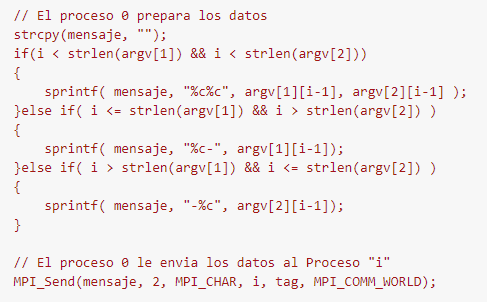

  Para los procesos que no sean el 0, se quedaran bloqueados (ya que se utilizan un pase de mensajes bloqueante) esperando a recibir el dato. Una vez que reciben el dato le realizan las operaciones correspondientes y le devuelven un "|" si es un match, un "*" si no es un mismatch y un " " si es un Gap. La devolucion se realiza al proceso 0 cuando éste lo habilite.

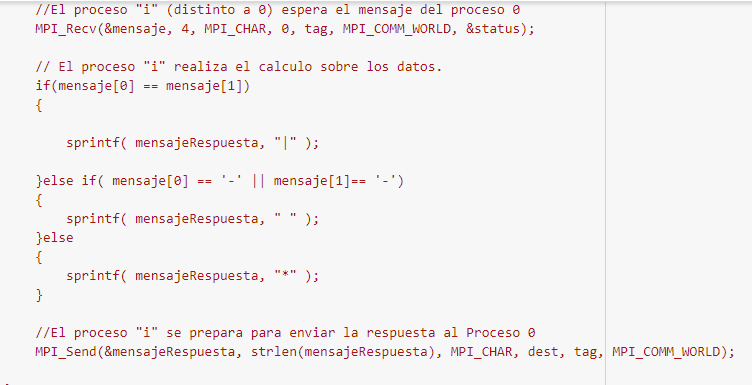

  Luego de enviar todos los datos a todos los procesos. El proceso 0 espera la respuesta de cada uno de los otros procesos. Los otros procesos si ya estan listos para enviar el mensaje, el proceso 0 lo recibe y lo trata y luego vuelve a esperar el mensaje del proceso siguiente. Al ser todas las funciones bloqueantes (funcion de enviar y recibir) el proceso 0 enviara (y recibira) los elementos de la cadena en el mismo orden en que estan.

  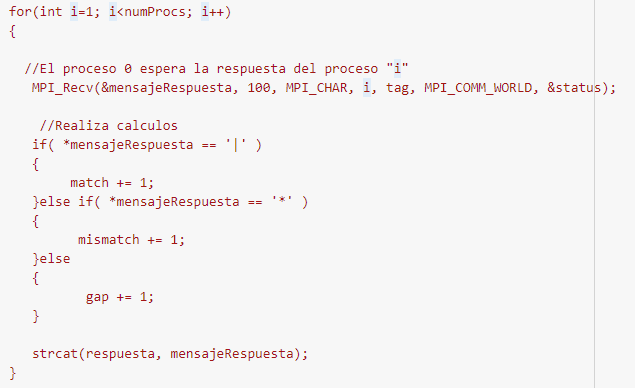

  Gracias a esto podemos hacer que varios calculos se ejecuten en diferentes procesos concurrentemente y mejorar el tiempo de ejecucion.

   Como vemos los procesos, distintos al proceso cero, se encargan de la comparacion de ambos char, mientras que el proceso cero se encarga de enviar los datos para esos procesos y de tratar el resultado que devuelven estos.

   Como agregado al codigo de Python en el cual se prepara la Linea de ejecucion del programa MPI, se realiza una request POST a Firebase, el cual envia una notificacion a todos los usuarios de la aplicacion de sensores (EA 2). Para activarlo instale la APK de la aplicacion y ingrese en ella. Una vez en ella se subscribira automaticamente para recibir mensajes del topic "all" el cual es el Topic que se envia este mensaje.

# 6 Bibliografia

1. Comparacion y Alineamiento de Secuencias de ADN: https://es.wikipedia.org/wiki/Alineamiento_de_secuencias
2. Comparacion de Secuencias diapositiva: https://bioinfo2.ugr.es/presentaciones/EvolMol/ComparacionSecuencias.pdf
3. Request POST a Firebase https://firebase.google.com/docs/cloud-messaging/http-server-ref
4. Utilizacion de Gaps en la cadena de ADN o de Proteinas https://sci-hub.se/https://pubmed.ncbi.nlm.nih.gov/21356856/